# Pratical session on Image Retrieval

In this practical session, we will explore how to perform typical tasks associated with image retrieval. Students will be able to download this IPython/Jupyter notebook after the class in order to perform the experiments also at home. 

**Link to the slides**: [PDF 30MB](https://www.dropbox.com/s/mjmh8al5wg6731j/18_07_PAISS_practical_session.pdf?dl=0)

## Installation

This code requires Python 3, Pytorch 0.4, and Jupyter Notebook. Follow the instructions below to install all the necessary dependencies.

### Installing dependencies

First, download and install the appropriate version of miniconda following the instructions for [MacOS](https://conda.io/docs/user-guide/install/macos.html) or [Linux](https://conda.io/docs/user-guide/install/linux.html).

Then run the following commands:

```
source $HOME/miniconda3/bin/activate #Activates your conda environment
conda install numpy matplotlib ipython scikit-learn jupyter pandas
conda install pytorch torchvision faiss-cpu -c pytorch
```


### Downloading the code, dataset, and models

First, clone this repository:

```
cd $HOME/my_projects
git clone https://github.com/rafarez/paiss.git
```

Then, you will need to download 4 files:

- oxbuild_images.tgz (1.8GB)
- gt\_files\_170407.tgz (280KB)
- features.tgz (579MB)
- models.tgz (328MB)

and store them in the appropriate paths.

_Note:_ All paths in this section are relative to the root directory of this repository.

#### Oxford dataset

On Linux/MacOS, execute the following:

```
cd $HOME/my_projects/paiss
wget www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz -O images.tgz
mkdir -p data/oxford5k/jpg && tar -xzf images.tgz -C data/oxford5k/jpg
wget www.robots.ox.ac.uk/~vgg/data/oxbuildings/gt_files_170407.tgz -O gt_files.tgz
mkdir -p data/oxford5k/lab && tar -xzf gt_files.tgz -C data/oxford5k/lab
```


#### Features and models

On Linux/MacOS, execute the following:

```
cd $HOME/my_projects/paiss
wget https://www.dropbox.com/s/gr404xlfr4021pw/features.tgz?dl=1 -O features.tgz
tar -xzf features.tgz -C data
wget https://www.dropbox.com/s/mr4risqu7t9neel/models.tgz?dl=1 -O models.tgz
tar -xzf models.tgz -C data
```



#### Running the notebook

```
cd $HOME/my_projects/paiss
jupyter notebook --ip='localhost' --port=61230 --NotebookApp.token=''
```

# Preparatives

We start by importing the necessary modules and fixing a random seed.

In [60]:
import numpy as np
from numpy.linalg import norm
import torch
from torch import nn
import json
import pdb
import sys
import os.path as osp
import pandas as pd

from datasets import create
from archs import *
from utils.test import extract_query
from utils.tsne import do_tsne

np.random.seed(0)

We then instantiate the Oxford dataset, that we will use in all following experiments.

In [42]:
# create Oxford 5k database
dataset = create('Oxford')

We can now query for some aspects of this dataset, such as the number of images, number of classes, the name of the different classes, and the class label for each of the images in the dataset

In [61]:
print('Dataset: ' + dataset.dataset_name)
print()

labels = dataset.get_label_vector()
classes = dataset.get_label_names()

print('Number of images:  ' + str(labels.shape))
print('Number of classes: ' + str(classes.shape))
print()
print('Class names: ' + str(classes))

Dataset: Oxford

Number of images:  (5063,)
Number of classes: (11,)

Class names: ['all_souls' 'ashmolean' 'balliol' 'bodleian' 'christ_church' 'cornmarket'
 'hertford' 'keble' 'magdalen' 'pitt_rivers' 'radcliffe_camera']


In [62]:
# load the dictionary of the available models and features
with open('data/models.json', 'r') as fp:
    models_dict = json.load(fp)

pd.DataFrame(models_dict).T # show the loaded models onscreen

,dataset,queries,training,weights
alexnet-cls-imagenet-fc7,data/features/alexnet-cls-imagenet-fc7_ox.npy,data/features/alexnet-cls-imagenet-fc7_oxq.npy,NaN,NaN
alexnet-cls-lm-fc7,data/features/alexnet-cls-lm-fc7_ox.npy,data/features/alexnet-cls-lm-fc7_oxq.npy,NaN,NaN
alexnet-cls-lm-gem,data/features/alexnet-cls-lm_ox.npy,data/features/alexnet-cls-lm_oxq.npy,NaN,NaN
resnet18-cls-imagenet-gem,data/features/resnet18-cls-imagenet_ox.npy,data/features/resnet18-cls-imagenet_oxq.npy,NaN,NaN
resnet18-cls-lm-gem,data/features/resnet18-cls-lm_ox.npy,data/features/resnet18-cls-lm_oxq.npy,NaN,NaN
resnet18-cls-imagenet-gem-pcaw,data/features/resnet18-cls-imagenet-pca_ox.npy,data/features/resnet18-cls-imagenet-pca_oxq.npy,NaN,NaN
resnet18-cls-lm-gem-pcaw,data/features/resnet18-cls-lm-pca_ox.npy,data/features/resnet18-cls-lm-pca_oxq.npy,NaN,NaN
resnet18-rnk-lm-gem,data/features/resnet18-rnk-lm_ox.npy,data/features/resnet18-rnk-lm_oxq.npy,NaN,NaN
resnet18-rnk-lm-gem-da,data/features/resnet18-rnk-lm-da_ox.npy,data/features/resnet18-rnk-lm-da_oxq.npy,NaN,data/models/resnet18-rnk-lm-da.pt
resnet18-rnk-lm-gem-da-mr,data/features/resnet18-rnk-lm-da_mr_ox.npy,data/features/resnet18-rnk-lm-da_mr_oxq.npy,NaN,data/models/resnet18-rnk-lm-da.pt


In [63]:
# preselected queries for visualization for each section. 
preselected_queries = {}
preselected_queries['1a'] = 11
preselected_queries['1b'] = 11
preselected_queries['1c'] = 11
preselected_queries['1d'] = 50
preselected_queries['1e'] = 50
preselected_queries['1f'] = 50
preselected_queries['2a'] = 42
preselected_queries['2b'] = 42
preselected_queries['2c'] = 7

# Part 1: Training

## a) Creating a network with the AlexNet architecture

As a first step, we will be creating a neural network implementing the AlexNet architecture to use in our experiments.

In [64]:
# instantate the model for the first experiment
model_1a = alexnet_imagenet()

# show the network details
print(model_1a)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

Now, we could use this model to extract features for all images in our dataset. In order to make this faster, we have already precomputed those features and stored them in the disk.

In order to load the features computed by this model from the disk, run the cell below:

In [65]:
dfeats = np.load(models_dict['alexnet-cls-imagenet-fc7']['dataset'])

In [66]:
pd.DataFrame(dfeats)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-0.035850,-0.027481,-0.002729,-0.001876,0.000510,-0.026890,-0.031041,0.008593,-0.036306,-0.011108,...,-0.000412,-0.031039,-0.011067,-0.017820,-0.013743,0.002906,-0.013534,-0.010850,-0.007984,-0.009079
1,-0.019589,-0.024991,0.003753,-0.016643,-0.001419,-0.025324,-0.030376,-0.015020,-0.033136,-0.008341,...,-0.011891,-0.025685,-0.012602,-0.019166,-0.008587,-0.010230,-0.015686,-0.003145,-0.027240,-0.005164
2,-0.031182,-0.015624,0.003333,-0.010716,-0.000947,-0.037874,-0.024973,-0.022489,-0.024565,-0.005231,...,-0.004073,-0.022185,-0.011347,-0.011516,-0.016464,-0.009736,-0.011495,-0.011072,-0.034790,-0.005476
3,-0.018782,-0.022565,0.002240,-0.010076,-0.001437,-0.020373,-0.020782,-0.029803,-0.025968,-0.005636,...,-0.002036,-0.015342,-0.007680,-0.017931,-0.013359,-0.027249,-0.012993,0.000823,-0.041952,0.002931
4,-0.016079,-0.034830,-0.011318,-0.011594,-0.001433,-0.015717,-0.019140,-0.014942,-0.027230,-0.001502,...,-0.008466,-0.026986,-0.014449,-0.024464,-0.024707,-0.029167,-0.015347,-0.011359,-0.034020,-0.010275
5,-0.027226,-0.019598,0.002683,-0.018460,-0.002139,-0.034594,-0.020992,-0.021336,-0.028204,-0.004704,...,-0.004012,-0.021141,-0.012326,-0.013401,-0.012377,-0.015479,-0.010811,-0.012446,-0.042647,-0.002835
6,-0.020550,-0.007709,-0.000061,-0.010187,-0.000725,-0.028299,-0.022015,-0.020881,-0.003965,0.002100,...,-0.007808,-0.027547,-0.007727,-0.017005,-0.013676,-0.014634,-0.014620,-0.006139,-0.039100,-0.000403
7,-0.025968,-0.023937,0.003283,-0.019003,-0.001922,-0.033658,-0.013863,-0.016475,-0.026929,-0.005424,...,-0.005924,-0.025334,-0.012016,-0.018541,-0.009853,-0.015122,-0.012085,-0.008246,-0.040714,-0.006721
8,-0.028738,-0.019763,0.004495,-0.010969,-0.001037,-0.035472,-0.024952,-0.001374,-0.019975,-0.005449,...,-0.004924,-0.013961,-0.010573,-0.020533,-0.017181,-0.007581,-0.009856,-0.000078,-0.032787,0.006912
9,-0.038494,0.011658,-0.000689,-0.011762,0.001312,-0.029404,-0.032518,-0.013561,0.012424,0.003670,...,-0.016833,-0.005571,-0.015611,-0.017843,-0.023685,-0.013018,-0.014558,-0.006085,0.001898,0.006085


**Question 1**: What does each line of the matrix feats represent?

**Question 2**: Where does the dimension of these lines comes from and how do we extract these features?

In [67]:
# Hint: uncomment and run the following command
#model_1a_test = alexnet_imagenet_fc7(); print(model_1a_test)

Now, assuming that we have already used our network to extract features from all images in the dataset and stored them in the matrix *dfeats*, we will retrieve the top-15 images that are most similar to a query image. In our example, we will use the following image as a query:

In [68]:
q_idx = preselected_queries['1a'] # feel free to switch to another number afterwards, but test first with 11

AP=12.73


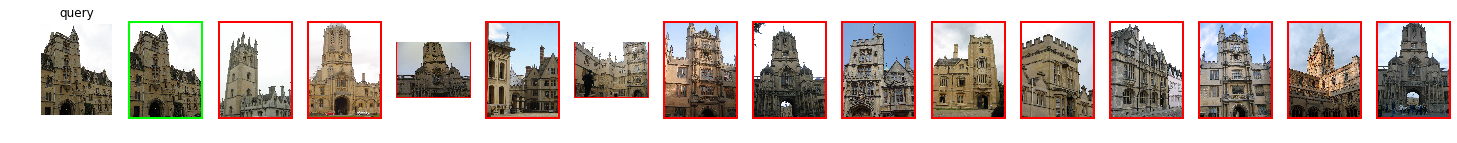

In [ ]:
# visualize top results for a given query
dataset.vis_top(dfeats, q_idx, ap_flag=True)

Now we will use the t-SNE algorithm to cluster images together according to feature similarity:

In [ ]:
do_tsne(dfeats, labels, classes, sec='1a')

**Question 3**: What can be observe from the t-SNE visualization? Which classes 'cluster' well? Which do not?

## b) Finetuning the created network on the Landmarks dataset

Now, we will see what happens when we fine-tune our off-the-shelf ImageNet network in the Landmarks dataset and then repeat the process above. 

**Question 4**: Should we get better results? What should change? Why?

In [ ]:
# instantate the model that has been fine-tuned in landmarks
model_1b = alexnet_lm()

print(model_1b)
# show the network details

Compare with the model we had before:

In [ ]:
print(model_1a)

**Question 5**: Why do we change the last layer of the AlexNet architecture? How do we initialize the layers of model_1b for finetuning?

Let's now repeat the same process we had done before, but now using image features that have been extracted using the fine-tuned network.

In [ ]:
dfeats = np.load(models_dict['alexnet-cls-lm-fc7']['dataset'])
pd.DataFrame(dfeats)

Visualize the top-15 most similar images:

In [ ]:
q_idx = preselected_queries['1b']
dataset.vis_top(dfeats, q_idx, ap_flag=True)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1b')

**Question 6**: How does the visualization change after finetuning? What about the top results?

**Question 7**: Question on how the architecture demands the resize of the input images (specifically, the fully connected layers) ##########

## c) Replacing last max pooling layer with GeM layer

Now, we will replace the last max pooling layer of our network with a GeM layer and see how this affects the results. For this model, we remove all fully connected layers (classifier layers) and replace the last max pooling layer by an aggregation pooling layer (more details about this layer in the next subsection).

In [ ]:
model_1c = alexnet_GeM()
print(model_1c)

We assume again we have used this model to extract features from all images and stored them in the *dfeats* variable:

In [ ]:
dfeats = np.load(models_dict['alexnet-cls-lm-gem']['dataset'])

pd.DataFrame(dfeats)

**Question**: Why does the size of the feature representation changes?

**Question**: Why does the size of the feature representation is important for a image retrieval task?

Visualize the top-15 most similar images:

In [ ]:
q_idx = preselected_queries['1c']
dataset.vis_top(dfeats, q_idx, ap_flag=True)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1c')

**Question**: How does the aggregation layer changes the t-SNE visualization? 
    
**Question**: Can we see some structure in the clusters of similarly labeled images?

## d) ResNet18 architecture with GeM pooling

Now, we will replace the base architecture of our network (the backbone) with a ResNet18 architecture.

In [ ]:
model_0 = resnet18()
model_1d = resnet18_GeM()

# Show how the last layers of the two models are different
print(model_0.adpool)
print(model_1d.adpool)

**Question**: Why do we change the average pooling layer of the original Resnet18 architecture for a generalized mean pooling? What operation is the layer model_1d.adpool doing?

 * Hint: You can see the code of the generalized mean pooling in file pooling.py
 
Now let's do the same as before and visualize the features and top-15 most similar images to our query:

In [ ]:
# load oxford features from ResNet18 model
dfeats = np.load(models_dict['resnet18-cls-lm-gem']['dataset'])

pd.DataFrame(dfeats)

Let's use a different image for testing this time:

In [ ]:
q_idx = 50

Now, let's visualize the top-15 results for the given query index

In [ ]:
qfeats = np.load(models_dict['resnet18-cls-lm-gem-pcaw']['queries'])
dataset.vis_top(dfeats, q_idx, q_feat=qfeats[q_idx], ap_flag=True)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1d')

**Question**: How does this model compare with model 1c, that was trained in the same dataset for the same task?

**Question**: How does is compare to the finetuned models of 1b?

## e) PCA Whitening

Now we will investigate the effects of whitening our descriptors and queries. We will not be changing anything in the network.

In [ ]:
# We use a PCA learnt on landmarks to whiten the output features of 'resnet18-cls-lm-gem'
q_idx = preselected_queries['1et']
dfeats = np.load(models_dict['resnet18-cls-lm-gem-pcaw']['dataset'])
qfeats = np.load(models_dict['resnet18-cls-lm-gem-pcaw']['queries'])
dataset.vis_top(dfeats, q_idx, q_feat=qfeats[q_idx], ap_flag=True)

Visualize the data with t-SNE (excluding unlabeled images)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1e-1')

Visualize the data with t-SNE (including unlabeled images)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1e-2', show_unlabeled=True)

**Question**: What can we say about the separation of data when included unlabeled images?

**Question**: And the distribution of the unlabeled features?

**Question**: How can we train a model to separate labeled from unlabeled data?

## f) Finetuning on Landmarks for retrieval

Now we learn the architecture presented in 1e in and end-to-end manner for the retrieval task. The architecture includes a FC layer that replaces the PCA projection.

In [ ]:
dataset.vis_triplets(nplots=5)

In [ ]:
q_idx = preselected_queries['1f']
dfeats = np.load(models_dict['resnet18-rnk-lm-gem']['dataset'])
qfeats = np.load(models_dict['resnet18-rnk-lm-gem']['queries'])
dataset.vis_top(dfeats, q_idx, q_feat=qfeats[q_idx], ap_flag=True)

Visualize the data with t-SNE (excluding unlabeled images)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1f-1')

Visualize the data with t-SNE (including unlabeled images)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1f-1', show_unlabeled=True)

**Question**: Compare the plots with unlabeled data of the model trained for retrieval (with triplet loss) and the model trained for classification of the previous subsection. How does it change?

## g) Data augmentation

This model has been trained the following data augmentation: cropping, pixel jittering, rotation, tilting, etc.

In [ ]:
dfeats = np.load(models_dict['resnet18-rnk-lm-gem-da']['dataset'])
qfeats = np.load(models_dict['resnet18-rnk-lm-gem-da']['queries'])
dataset.vis_top(dfeats, q_idx, q_feat=qfeats[q_idx], ap_flag=True, out_image_file=out_image)

Visualize the data with t-SNE (excluding unlabeled images)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1g')

**Question**: TODO

## h) Multi-resolution

Using the same model as the one in sect-1g, we extract features at 4 different resolutions and average the outputs

In [ ]:
dfeats = np.load(models_dict['resnet18-rnk-lm-gem-da-mr']['dataset'])
qfeats = np.load(models_dict['resnet18-rnk-lm-gem-da-mr']['queries'])
dataset.vis_top(dfeats, q_idx, q_feat=qfeats[q_idx], ap_flag=True, out_image_file=out_image)    

Visualize the data with t-SNE (excluding unlabeled images)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1h')

**Question**: _TODO_

# i) Improved architecture

Finally, we upgrade the backbone architecture to Resnet50

In [ ]:
dfeats = np.load(models_dict['resnet50-rnk-lm-gem-da-mr']['dataset'])
qfeats = np.load(models_dict['resnet50-rnk-lm-gem-da-mr']['queries'])
dataset.vis_top(dfeats, q_idx, q_feat=qfeats[q_idx], ap_flag=True, out_image_file=out_image)

Visualize the data with t-SNE (excluding unlabeled images)

In [ ]:
do_tsne(dfeats, labels, classes, sec='1i')

**Question**: _TODO_

# Section 2: Testing

In this section, we will


## a) Robustness to input transformations

In [ ]:
q_idx = 42

Original image:

In [ ]:
q_feat1, raw_img = extract_query(model1, dataset, q_idx)
    dataset.vis_top(dfeats1, q_idx, q_feat1, ap_flag=True, query_image=raw_img)

Flipping the query image

In [ ]:
 q_feat1_flip, raw_img = extract_query(model1, dataset, q_idx, flip=True)
    dataset.vis_top(dfeats1, q_idx, q_feat1_flip, ap_flag=True, query_image=raw_img)
    # Q1: What is the impact of flipping the query image?

**Question**: What is the impact of flipping the query image?

Standard trick: aggregate both no-flipped and flipped representations

Original + flipped image    

In [ ]:
q_feat1_new = (q_feat1 + q_feat1_flip)
q_feat1_new = q_feat1_new / norm(q_feat1_new) # Don't forget to l2-normalize again :)
dataset.vis_top(dfeats1, q_idx, q_feat1_new, ap_flag=True)

Rotating the query image

Rotated image with vanilla model

In [ ]:
q_feat1_rot, raw_img = extract_query(model1, dataset, q_idx, rotate=10.)
dataset.vis_top(dfeats1, q_idx, q_feat1_rot, ap_flag=True, query_image=raw_img)

Rotated image with augmented model

In [ ]:
q_feat2_rot, raw_img = extract_query(model2, dataset, q_idx, rotate=10.)
dataset.vis_top(dfeats2, q_idx, q_feat2_rot, ap_flag=True, query_image=raw_img)

**Question**: Change the rotation value (in +/- degrees). 
- What is the impact of rotating it?
- Up to which degree of rotation is the result stable?
- How does the models (model1 trained without image rotation, model2 trained with) compare?

## b)  Robustness to resolution changes

Extract features using a larger input scale: 1200px

q_feat, raw_img = extract_query(model2, dataset, q_idx, scale=1200)
dataset.vis_top(dfeats2, q_idx, q_feat, ap_flag=True, query_image=raw_img, out_image_file=out_image)

**Question**: Resize the image by a factor. What is the impact of resizing it, especially to very low resolution?

## c) Queries with multi-scale features

In [ ]:
q_idx = 7

In [ ]:
# Extract features using a single input scale: 800px
q_feat, raw_img = extract_query(model1, dataset, q_idx, scale=800)
dataset.vis_top(dfeats1, q_idx, q_feat, ap_flag=True, query_image=raw_img)

# Aggregate features extracted at several input sizes: [600, 800, 1000, 1200]
features = [q_feat]
for scale in [600, 1000, 1200]:
    q_feat, raw_img = extract_query(model1, dataset, q_idx, scale=scale)
    features.append(q_feat)
q_feat_mr = np.mean(np.vstack(features), axis=0)
# L2 normalize again
q_feat_mr = q_feat_mr / norm(q_feat_mr)
dataset.vis_top(dfeats1, q_idx, q_feat_mr, ap_flag=True, query_image=raw_img)
# Q: What is the impact of using more scales?

## d) Robustness to compression (using PQ)

In [ ]:
dataset.vis_top(dfeats2, q_idx, ap_flag=True)

m = 256      # number of subquantizers
n_bits = 8   # bits allocated per subquantizer

feats_train = np.load(models_dict['resnet50-rnk-lm-gem-da']['training'])
print ('Training K-means for PQ...')
dataset.pq_train(feats_train, m, n_bits)

# dataset to encode
print ('Encoding features...')
dataset.pq_add(dfeats2)

# search:
dataset.vis_top(dfeats2, q_idx, pq_flag=True, ap_flag=True)
# Q1: How much memory (in bytes) is needed to store the compressed representation?
# Q2: What is the compression ratio?
# Q3: How did the compression affect the retrieval results?
# Q4: Change the values and m & n_bit and observe the change in retrieval performance.

In [ ]:
## Subsection 2e: Average query expansion

dataset.vis_top(dfeats2, q_idx, q_feat=qfeats2[q_idx], nqe=3, ap_flag=True)
# nqe is the number of database items with which to expand the query.
# Q1: What is the impact of using different values of nqe?

In [ ]:
## Subsection 2f: alpha query expansion

dataset.vis_top(dfeats2, q_idx, q_feat=qfeats2[q_idx], nqe=5, aqe=3.0, ap_flag=True)
# aqe is the value of alpha applied for alpha query expansion.
# Q1: How should nqe be chosen? Hint: What is the impact of low prec@K (where K is equivalent to nqe) on aqe?
# Q2: What is the impact of using different values of nqe, aqe?

In [ ]:
## Subsection 2g: Diffusion

dataset.vis_top(dfeats2, q_idx, q_feat=qfeats2[q_idx], dfs='it:int20', ap_flag=True)
# Parameters for dfs are passed as strings with datatypes indicated. The default parameter string is:
#    'alpha:float0.99_it:int20_tol:float1e-6_gamma:float3_ks:100-30_trunc:bool_bsize:int100000_fsr:bool_IS:bool_wgt:bool_bs:bool_reg:bool_split:int0_gmp:bool'
#    strings passed to the dfs parameter overwrite the default parameters

# Q1: The affinity matrix is computed using the similarity measure s = <f_i, f_j>^alpha, where 0 < alpha <= 1.0. Use dfs='alpha:float<alpha>' for different values of alpha. What is the impact of changing it? E.g:
dataset.vis_top(dfeats2, q_idx, q_feat=qfeats2[q_idx], dfs='alpha:float0.8', ap_flag=True)

# Q2: k_q is the number of database items to use for diffusion. Use dfs='ks:100-<k_q>' for different values of k_q. What is the impact of changing it? E.g:
dataset.vis_top(dfeats2, q_idx, q_feat=qfeats2[q_idx], dfs='ks:100-5', ap_flag=True)

# Q3: trunc is the number of sub-rows and columns to use for diffusion. Use dfs='trunc:int<trunc>' for different values of trunc. What is the impact of changing it? E.g:
dataset.vis_top(dfeats2, q_idx, q_feat=qfeats2[q_idx], dfs='trunc:int2000', ap_flag=True)
# Q4: What is the maximum value of trunc and what case does it generalize to?
